# Bot vs random agent

To test the performance of the bots in an objective manner, the win rate against a random agent is determined along with the average length of a game.

<hr><hr>

## Table of Contents

- Contact information
- Checking requirements
  - Correct Anaconda environment
  - Correct module access
  - Correct CUDA access
- Setting up the environment
- Loading policies
  - MLP based DQN
  - CNN based DQN
  - CNN based Rainbow
  - MiniMax policy
- Loading in torch dictionaries
- Agent manager and win rate tester
- Setup the experiment

<hr><hr>

## Contact information

| Name             | Student ID | VUB mail                                                  | Personal mail                                               |
| ---------------- | ---------- | --------------------------------------------------------- | ----------------------------------------------------------- |
| Lennert Bontinck | 0568702    | [lennert.bontinck@vub.be](mailto:lennert.bontinck@vub.be) | [info@lennertbontinck.com](mailto:info@lennertbontinck.com) |



<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `rl-project` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the RL course project and homeworks](https://github.com/pikawika/vub-rl).

In [2]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'rl-project'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: rl-project
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules and show if the versions match those that are recommended.

In [4]:
####################################################
# LOADING MODULES
####################################################

# Allow reloading of libraries
import importlib

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

# More data types
import typing
import numpy as np

# Pygame
import pygame; print(f"Pygame version (2.1.2 recommended): {pygame.__version__}")

# Gym environment
import gym; print(f"Gym version (0.21.0 recommended): {gym.__version__}")

# Tianshou for RL algorithms
import tianshou as ts; print(f"Tianshou version (0.4.8 recommended): {ts.__version__}")

# Torch is a popular DL framework
import torch; print(f"Torch version (1.12.0 recommended): {torch.__version__}")

# PPrint is a pretty print for variables
from pprint import pprint

# Our custom connect four gym environment
import sys
sys.path.append('../')
import gym_connect4_pygame.envs.ConnectFourPygameEnvV2 as cfgym
import minimax_agent.minimax_agent as minimaxbot
importlib.invalidate_caches()
importlib.reload(cfgym);
importlib.reload(minimaxbot);

Matplotlib version (3.5.1 recommended): 3.5.1
Pygame version (2.1.2 recommended): 2.1.2
Gym version (0.21.0 recommended): 0.21.0
Tianshou version (0.4.8 recommended): 0.4.8
Torch version (1.12.0 recommended): 1.12.0.dev20220520+cu116


<hr>

### Correct CUDA access

The installation instructions specify how to install PyTorch with CUDA 11.6.
The following code block tests if this was done successfully.

In [5]:
####################################################
# CUDA VALIDATION
####################################################

# Check cuda available
print(f"CUDA is available: {torch.cuda.is_available()}")

# Show cuda devices
print(f"\nAmount of connected devices supporting CUDA: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    # Show current cuda device
    print(f"\nCurrent CUDA device: {torch.cuda.current_device()}")

    # Show cuda device name
    print(f"Cuda device 0 name: {torch.cuda.get_device_name(0)}")

CUDA is available: True

Amount of connected devices supporting CUDA: 1

Current CUDA device: 0
Cuda device 0 name: NVIDIA GeForce GTX 970


<hr><hr>

## Setting up the environment

In [41]:
####################################################
# CONNECT FOUR V2 ENVIRONMENT
####################################################

def get_env():
    """
    Returns the connect four gym environment V2 altered for Tianshou and Petting Zoo compatibility.
    Already wrapped with a ts.env.PettingZooEnv wrapper.
    Set up for testing the win rate, thus only a reward is given for winning (10).
    """
    return ts.env.PettingZooEnv(cfgym.env(reward_move= 0,
                                          reward_blocking= 0,
                                          reward_invalid= 0,
                                          reward_draw= 0,
                                          reward_win= 10,
                                          reward_loss= 0,
                                          allow_invalid_move= False))
    
    
# Test the environment
env = get_env()
print(f"Observation space: {env.observation_space}")
print(f"\nAction space: {env.action_space}")

# Reset the environment to start from a clean state, returns the initial observation
observation = env.reset()

print("\n Initial player id:")
print(observation["agent_id"])

print("\n Initial observation:")
print(observation["obs"])

print("\n Initial mask:")
print(observation["mask"])

# Clean unused variables
del observation
del env

Observation space: Dict(action_mask:Box([0 0 0 0 0 0 0], [1 1 1 1 1 1 1], (7,), int8), observation:Box([[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]], [[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]], (6, 7), int8))

Action space: Discrete(7)

 Initial player id:
player_1

 Initial observation:
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]

 Initial mask:
[True, True, True, True, True, True, True]


<hr><hr>

## Loading policies

We need to specify the policies the trained agent's weight are for.
These are taken from previous notebooks.

<hr>

### MLP based DQN

In [42]:
####################################################
# DQN POLICY FROM PAPER NOTEBOOK 5
####################################################

class CustomDQN(torch.nn.Module):
    """
    Custom DQN using a model based on CNN
    """
    def __init__(self,
                 state_shape: typing.Sequence[int],
                 action_shape: typing.Sequence[int],
                 device: typing.Union[str, int, torch.device] = 'cuda' if torch.cuda.is_available() else 'cpu',):
        # Parent call
        super().__init__()
        
        # Save device (e.g. cuda)
        self.device = device
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(np.prod(state_shape), 128), torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, 128), torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, 128), torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, np.prod(action_shape)),
        )

    def forward(self, obs, state=None, info={}):
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float, device=self.device)
        batch = obs.shape[0]
        logits = self.model(obs.view(batch, -1))
        return logits, state

def cf_custom_dqn_policy(state_shape: tuple,
                         action_shape: tuple,
                         learning_rate: float =  0.0001,
                         gamma: float = 0.9, # Smaller gamma favours "faster" win
                         n_step: int = 1, # Number of steps to look ahead
                         target_update_freq: int = 320):
    # Use cuda device if possible
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Network to be used for DQN
    net = CustomDQN(state_shape, action_shape, device= device).to(device)
    
    # Default optimizer is an adam optimizer with the argparser learning rate
    optim = torch.optim.Adam(net.parameters(), lr= learning_rate)
        
    # Our agent DQN policy
    return ts.policy.DQNPolicy(model= net,
                               optim= optim,
                               discount_factor= gamma,
                               estimation_step= n_step,
                               target_update_freq= target_update_freq)

<hr>

### CNN based DQN

In [43]:
####################################################
# DQN POLICY FROM PAPER NOTEBOOK 7
####################################################

class CNNBasedDQN(torch.nn.Module):
    """
    Custom DQN using a model based on CNN
    """
    def __init__(self,
                 state_shape: typing.Sequence[int],
                 action_shape: typing.Sequence[int],
                 device: typing.Union[str, int, torch.device] = 'cuda' if torch.cuda.is_available() else 'cpu',):
        # Parent call
        super().__init__()
        
        # Save device (e.g. cuda)
        self.device = device
        
        # Number of input channels
        input_channels_cnn = 1
        output_channels_cnn = 32
        flatten_size = (state_shape[0] - 3) * (state_shape[1] - 3) * output_channels_cnn
        output_size= np.prod(action_shape)
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels= input_channels_cnn, out_channels= output_channels_cnn, kernel_size= 4, stride= 1), torch.nn.ReLU(inplace=True),
            torch.nn.Flatten(0,-1),
            torch.nn.Unflatten(0, (1, flatten_size)),
            torch.nn.Linear(flatten_size, 128), torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, 128), torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, output_size),
        )

    def forward(self, obs, state=None, info={}):
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float, device=self.device)
        
        logits = self.model(obs)
        return logits, state

    
def cf_cnn_dqn_policy(state_shape: tuple,
                      action_shape: tuple,
                      optim: typing.Optional[torch.optim.Optimizer] = None,
                      learning_rate: float =  0.0001,
                      gamma: float = 0.9, # Smaller gamma favours "faster" win
                      n_step: int = 4, # Number of steps to look ahead
                      frozen: bool = False,
                      target_update_freq: int = 320):
    # Use cuda device if possible
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Network to be used for DQN
    net = CNNBasedDQN(state_shape, action_shape, device= device).to(device)
    
    # Default optimizer is an adam optimizer with the argparser learning rate
    if optim is None:
        optim = torch.optim.Adam(net.parameters(), lr= learning_rate)
        
    # If we are frozen, we use an optimizer that has learning rate 0
    if frozen:
        optim = torch.optim.SGD(net.parameters(), lr= 0)
        
        
    # Our agent DQN policy
    return ts.policy.DQNPolicy(model= net,
                               optim= optim,
                               discount_factor= gamma,
                               estimation_step= n_step,
                               target_update_freq= target_update_freq)

<hr>

### CNN based Rainbow

<hr>

### CNN based DQN

In [44]:
####################################################
# RAINBOW POLICY FROM PAPER NOTEBOOK 9
####################################################

class CNNForRainbow(torch.nn.Module):
    """
    Custom CNN to be used as baseclass for the Rainbow algorithm.
    Extracts "feautures" for the Rainbow algorithm by doing a 4x4 cnn kernel pass and providing 16 filters.
    """
    def __init__(self,
                 state_shape: typing.Sequence[int],
                 device: typing.Union[str, int, torch.device] = 'cuda' if torch.cuda.is_available() else 'cpu'):
        
        # Torch init
        super().__init__()
        
        # Store device to be used
        self.device = device
        
        # The input layer is singular -> we have 1 board vector
        input_channels_cnn = 1
        
        # We output 64/16 filters per kernel 
        output_channels_cnn = 64 # Increased from 16
        
        # We store the output dimension of the CNN "feature" layer
        self.output_dim = (state_shape[0] - 3) * (state_shape[1] - 3) * output_channels_cnn
        
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels= input_channels_cnn, out_channels= output_channels_cnn, kernel_size= 4, stride= 1), torch.nn.ReLU(inplace=True),
            torch.nn.Flatten(),
        )

    def forward(self,
                obs: typing.Union[np.ndarray, torch.Tensor],
                state: typing.Optional[typing.Any] = None,
                info: typing.Dict[str, typing.Any] = {}):
        # Make a torch instance (from regular vector of board)
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float, device=self.device)
            
        # Tianshou bugs the batch output, reshape to work properly with our torch version
        if (len(np.shape(obs)) != 4):
            obs = obs[:, None, :, :]
        
        # Return what is needed (network output & state)
        return self.net(obs), state

class Rainbow(CNNForRainbow):
    """
    Implementation of the Rainbow algorithm making using of the CNNForRainbow baseclass.
    Default parameters adopted from: https://github.com/thu-ml/tianshou/blob/master/examples/atari/atari_rainbow.py
    """

    def __init__(self,
                 state_shape: typing.Sequence[int],
                 action_shape: typing.Sequence[int],
                 device: typing.Union[str, int, torch.device] = 'cuda' if torch.cuda.is_available() else 'cpu',
                 num_atoms: int = 51,
                 is_noisy: bool = True,
                 noisy_std: float = 0.1,
                 is_dueling: bool = True):
        
        # Init CNN feature extraction parent class
        super().__init__(state_shape= state_shape, device= device)
        
        # the amount of actions we have is just the action shape
        self.action_num = np.prod(action_shape)
        
        # Store class specific info
        self.num_atoms = num_atoms
        self._is_dueling = is_dueling

        # Our linear layer depends on wether or not we want to use a noisy environment
        # Noisy implementation based on https://arxiv.org/abs/1706.10295
        def linear(x, y):
            if is_noisy:
                return ts.utils.net.discrete.NoisyLinear(x, y, noisy_std)
            else:
                return torch.nn.Linear(x, y)
            
        # Specify Q and V based on wether or not agent is dueling
        # Setting agent on dueling mode should help generalisation according to rainbow paper
        # NOTE: this uses the output dim from the feature extraction CNN
        self.Q = torch.nn.Sequential(
            linear(self.output_dim, 512), torch.nn.ReLU(inplace=True),
            linear(512, self.action_num * self.num_atoms))
        
        if self._is_dueling:
            self.V = torch.nn.Sequential(
                linear(self.output_dim, 512), torch.nn.ReLU(inplace=True),
                linear(512, self.num_atoms))
            
        # New output dim for this rainbow network
        self.output_dim = self.action_num * self.num_atoms
        

    def forward(self,
                obs: typing.Union[np.ndarray, torch.Tensor],
                state: typing.Optional[typing.Any] = None,
                info: typing.Dict[str, typing.Any] = {}):
        
        # Use our parent CNN based network to get "features"
        obs, state = super().forward(obs)
        
        # Get our Rainbow specific values
        q = self.Q(obs)
        q = q.view(-1, self.action_num, self.num_atoms)
        
        if self._is_dueling:
            v = self.V(obs)
            v = v.view(-1, 1, self.num_atoms)
            logits = q - q.mean(dim=1, keepdim=True) + v
        else:
            logits = q
        
        # We need to go from our logits to an accepted dimension of probability outputs
        probs = logits.softmax(dim=2)
        
        return probs, state
    
    
def rainbow_policy(state_shape: tuple,
                   action_shape: tuple,
                   optim: typing.Optional[torch.optim.Optimizer] = None,
                   learning_rate: float =  0.0000625,
                   gamma: float = 0.9,
                   n_step: int = 3, # Number of steps to look ahead
                   num_atoms: int = 51,
                   is_noisy: bool = True,
                   noisy_std: float = 0.1,
                   is_dueling: bool = True,
                   target_update_freq: int = 500):
    """
    Implementation of the Rainbow policy.
    Default parameters adopted from: https://github.com/thu-ml/tianshou/blob/master/examples/atari/atari_rainbow.py
    """
    
    # Use cuda device if possible
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Rainbow network to be used by policy
    net = Rainbow(state_shape= state_shape,
                  action_shape= action_shape,
                  device= device,
                  num_atoms= num_atoms,
                  is_noisy= is_noisy,
                  noisy_std= noisy_std,
                  is_dueling= is_dueling).to(device)
    
    # Default optimizer is an adam optimizer with the argparser learning rate
    if optim is None:
        optim = torch.optim.Adam(net.parameters(), lr= learning_rate)
        
    # Our agents Rainbow policy
    return ts.policy.RainbowPolicy(model= net,
                                   optim= optim,
                                   discount_factor= gamma,
                                   num_atoms= num_atoms,
                                   estimation_step= n_step,
                                   target_update_freq= target_update_freq).to(device)



<hr>

### MiniMax policy

In [45]:
####################################################
# CUSTOM MINIMAX TIANSHOU POLICY
####################################################

class TianshouMiniMaxConnectFourPolicy(ts.policy.BasePolicy):
    """
    Tianshou compatible MiniMax policy for connect four.
    """

    def __init__(self,
                 coin: int,
                 oponent_coin: int,
                 minimax_depth: int,
                 column_count: int = 7,
                 row_count: int = 6,
                 **kwargs: typing.Any):
        # Init base policy
        super().__init__(**kwargs)
        
        # Configure minimax bot
        self.bot = minimaxbot.MiniMaxConnectFourBot(coin= coin,
                                                    oponent_coin= oponent_coin,
                                                    column_count= column_count,
                                                    row_count= row_count,
                                                    minimax_depth= minimax_depth)

    def forward(self,
                batch: ts.data.Batch,
                state: typing.Optional[typing.Union[dict, ts.data.Batch, np.ndarray]] = None,
                **kwargs: typing.Any):
        """
        Compute minimax action over the given batch data.
        """
        boards = batch["obs"]
        
        # Can be nested in Tianshou
        while isinstance(boards, ts.data.Batch):
            boards = boards["obs"]
        
        preds = [None] * len(boards)        
        
        for i in range(len(boards)):
            preds[i] = self.bot.predict(board= boards[i])
            
        
        return ts.data.Batch(act=preds, state=state)
    
    def learn(self, batch, **kwargs):
        # No learning needed
        return {}
    
    def set_eps(self, eps):
        # Not needed
        return

    


<hr><hr>

## Loading in torch dictionaries



In [46]:
####################################################
# FUNCTION FOR LOADING IN TORCH DICTIONARIIES
####################################################

def load_torch_dict(filename):
    """
    Loads in torch dictionary using correct cuda settings for current device
    """   
    if torch.cuda.is_available():
        return torch.load(filename)
    else:
        return torch.load(filename, map_location=torch.device('cpu'))

<hr><hr>

## Agent manager and win rate tester


In [47]:
####################################################
# AGENT CREATION
####################################################

def get_agent_manager(agent_player1: typing.Optional[ts.policy.BasePolicy],
                      agent_player2: typing.Optional[ts.policy.BasePolicy]):
    """
    Gets a multi agent policy manager for the provided agents.
    """
    
    # Get the environment to play in (Connect four gym V2)
    env = get_env()

    # Default order of the agents
    agents = [agent_player1, agent_player2]
        
    # Create the multi agent policy
    policy = ts.policy.MultiAgentPolicyManager(agents, env)
    
    # Return our policy, optimizer and the available agents in the environment
    # Per default: 
    #   - Multi agent manager for 2 agents using Rainbow
    #   - Adam optimizer
    #   - ['player_1', 'player_2'] from the connect four environment
    
    return policy, env.agents

In [48]:
####################################################
# WATCHING THE LEARNED POLICY IN ACTION
####################################################

def test_win_rate(numer_of_games: int,
                  agent_player1: typing.Optional[ts.policy.BasePolicy],
                  agent_player2: typing.Optional[ts.policy.BasePolicy]):
    
    # Get the connect four V2 environment (must be a list)
    env= ts.env.DummyVectorEnv([get_env])
    
    # Get the agents from the trained agents
    policy, agents = get_agent_manager(agent_player1= agent_player1,
                                       agent_player2= agent_player2)
    
    # Evaluate the policy
    policy.eval()
    
    # Collect the test data
    collector = ts.data.Collector(policy= policy,
                                  env= env,
                                  exploration_noise= True)
    
    # Render games in human mode to see how it plays
    result = collector.collect(n_episode= numer_of_games)
    
    # Close the environment aftering collecting the results
    # This closes the pygame window after completion
    env.close()
    
    # Get the rewards and length from the test trials
    rewards, length = result["rews"], result["lens"]
    
    # Print the final reward for the first agent
    print(f"Played {numer_of_games} games.")
    print(f"Average steps of game:  {length.mean()}, std: {length.std()}")
    print(f"Final mean reward agent 1: {rewards[:, 0].mean()}, std: {rewards[:, 0].std()}")
    print(f"Final mean reward agent 2: {rewards[:, 1].mean()}, std: {rewards[:, 1].std()}")

<hr><hr>

## Setup the experiment

Results:
- P1 MLP DQN vs random
  - Score: 9.03, std: 2.9595776725742473
  - Length: 11.351, std: 7.226465180155509
- P2 MLP DQN vs random
  - Score: 8.03, std: 3.9773232204587043
  - Length: 12.321, std: 5.362644776600441
- P1 CNN DQN vs random
  - Score: 8.98, std: 3.0264831075028327
  - Length: 11.37, std: 6.58825470060167
- P2 CNN DQN vs random
  - Score: 7.98, std: 4.014922166119787
  - Length: 11.156, std: 5.5983626177660195
- P1 rainbow vs random:
  - Score: 9.49, std: 2.199977272609878
  - Length: 11.193, std: 5.6767729389152075
- P2 rainbow vs random
  - Score: 9.16, std: 2.77387815161373
  - Length: 11.812, std: 6.509120985202227

In [49]:
####################################################
# SETUP THE GAME
####################################################

# Configure the rainbow agent
random_agent = ts.policy.RandomPolicy()

# Configure best MLP DQN player 1
best_mlp_dqn_player1 = cf_custom_dqn_policy(state_shape= (6, 7),
                                            action_shape= (7,))
best_mlp_dqn_player1.load_state_dict(load_torch_dict("../paper_notebooks/./saved_variables/paper_notebooks/8/7-20epoch_500loop/looping-iteration-498/best_policy_agent1.pth"))
best_mlp_dqn_player1.set_eps(0.001) # not zero in case agent got stuck

# Configure best MLP DQN player 2
best_mlp_dqn_player2 = cf_custom_dqn_policy(state_shape= (6, 7),
                                            action_shape= (7,))
best_mlp_dqn_player2.load_state_dict(load_torch_dict("../paper_notebooks/./saved_variables/paper_notebooks/8/7-20epoch_500loop/looping-iteration-499/best_policy_agent2.pth"))
best_mlp_dqn_player2.set_eps(0.001) # not zero in case agent got stuck

# Configure best MLP CNN player 1
best_cnn_dqn_player1 = cf_cnn_dqn_policy(state_shape= (6, 7),
                                         action_shape= (7,))
best_cnn_dqn_player1.load_state_dict(load_torch_dict("../paper_notebooks/./saved_variables/paper_notebooks/7/7-20epoch_500loop/7-looping-iteration-498/best_policy_agent1.pth"))
best_cnn_dqn_player1.set_eps(0.001) # not zero in case agent got stuck

# Configure best MLP CNN player 2
best_cnn_dqn_player2 = cf_cnn_dqn_policy(state_shape= (6, 7),
                                         action_shape= (7,))
best_cnn_dqn_player2.load_state_dict(load_torch_dict("../paper_notebooks/./saved_variables/paper_notebooks/6/dqn_vs_dqn_cnn_based/best_policy_agent2.pth"))
best_cnn_dqn_player2.set_eps(0.001) # not zero in case agent got stuck

# Configure best rainbow player 1
best_rainbow_player1 = rainbow_policy(state_shape= (6, 7),
                                      action_shape= (7,))
best_rainbow_player1.load_state_dict(load_torch_dict("../paper_notebooks/./saved_variables/paper_notebooks/9/rainbow_vs_rainbow_blocking_reward_complex_cnn/best_policy_agent1.pth"))
best_rainbow_player1.set_eps(0.001) # not zero in case agent got stuck

# Configure best rainbow player 2
best_rainbow_player2 = rainbow_policy(state_shape= (6, 7),
                                      action_shape= (7,))
best_rainbow_player2.load_state_dict(load_torch_dict("../paper_notebooks/./saved_variables/paper_notebooks/9/rainbow_vs_rainbow_blocking_reward_complex_cnn/best_policy_agent2.pth"))
best_rainbow_player2.set_eps(0.001) # not zero in case agent got stuck

In [56]:
####################################################
# MLP DQN P1 TEST
####################################################

test_win_rate(numer_of_games=1000,
              agent_player1= best_mlp_dqn_player1,
              agent_player2= random_agent)

Played 1000 games.
Average steps of game:  11.351, std: 7.226465180155509
Final mean reward agent 1: 9.03, std: 2.9595776725742473
Final mean reward agent 2: 0.97, std: 2.9595776725742473


In [51]:
####################################################
# MLP DQN P2 TEST
####################################################

test_win_rate(numer_of_games=1000,
              agent_player1= random_agent,
              agent_player2= best_mlp_dqn_player2)

Played 1000 games.
Average steps of game:  12.321, std: 5.362644776600441
Final mean reward agent 1: 1.97, std: 3.977323220458704
Final mean reward agent 2: 8.03, std: 3.9773232204587043


In [52]:
####################################################
# CNN DQN P1 TEST
####################################################

test_win_rate(numer_of_games=1000,
              agent_player1= best_cnn_dqn_player1,
              agent_player2= random_agent)

Played 1000 games.
Average steps of game:  11.37, std: 6.58825470060167
Final mean reward agent 1: 8.98, std: 3.0264831075028327
Final mean reward agent 2: 1.02, std: 3.0264831075028327


In [53]:
####################################################
# CNN DQN P2 TEST
####################################################

test_win_rate(numer_of_games=1000,
              agent_player1= random_agent,
              agent_player2= best_cnn_dqn_player2)

Played 1000 games.
Average steps of game:  11.156, std: 5.5983626177660195
Final mean reward agent 1: 2.02, std: 4.014922166119787
Final mean reward agent 2: 7.98, std: 4.014922166119787


In [54]:
####################################################
# RAINBOW P1 TEST
####################################################

test_win_rate(numer_of_games=1000,
              agent_player1= best_rainbow_player1,
              agent_player2= random_agent)

Played 1000 games.
Average steps of game:  11.193, std: 5.6767729389152075
Final mean reward agent 1: 9.49, std: 2.199977272609878
Final mean reward agent 2: 0.5, std: 2.179449471770337


In [55]:
####################################################
# RAINBOW P2 TEST
####################################################

test_win_rate(numer_of_games=1000,
              agent_player1= random_agent,
              agent_player2= best_rainbow_player2)

Played 1000 games.
Average steps of game:  11.812, std: 6.509120985202227
Final mean reward agent 1: 0.84, std: 2.77387815161373
Final mean reward agent 2: 9.16, std: 2.77387815161373


<hr><hr>

## Plotting results

- P1 MLP DQN vs random
  - Score: 9.03, std: 2.9595776725742473
  - Length: 11.351, std: 7.226465180155509
- P2 MLP DQN vs random
  - Score: 8.03, std: 3.9773232204587043
  - Length: 12.321, std: 5.362644776600441
- P1 CNN DQN vs random
  - Score: 8.98, std: 3.0264831075028327
  - Length: 11.37, std: 6.58825470060167
- P2 CNN DQN vs random
  - Score: 7.98, std: 4.014922166119787
  - Length: 11.156, std: 5.5983626177660195
- P1 rainbow vs random:
  - Score: 9.49, std: 2.199977272609878
  - Length: 11.193, std: 5.6767729389152075
- P2 rainbow vs random
  - Score: 9.16, std: 2.77387815161373
  - Length: 11.812, std: 6.509120985202227

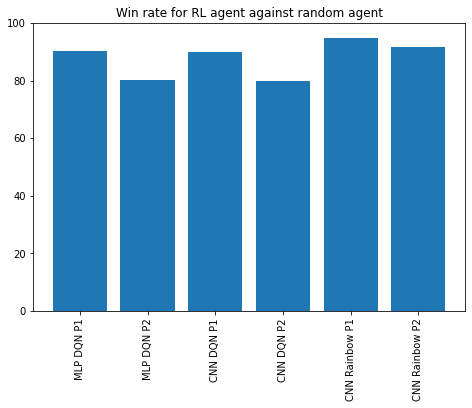

In [64]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
experiments = ['MLP DQN P1', 'MLP DQN P2', 'CNN DQN P1', 'CNN DQN P2', 'CNN Rainbow P1', 'CNN Rainbow P2']
win_rates = [90.3, 80.3, 89.8, 79.8, 94.9, 91.6]
ax.bar(experiments, win_rates)
ax.set_ylim([0, 100])
plt.xticks(rotation=90)
plt.title("Win rate for RL agent against random agent")
plt.show()